In [97]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [98]:
import os
os.chdir('/content/drive/MyDrive/Projects/reddit-vote-predictor')
import sys
if 'psaw' not in sys.modules:
  print('Installing psaw')
  os.system('pip install psaw')
import shutil as sh
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as s
from skimage import io
from mpl_toolkits.axes_grid1 import ImageGrid

Installing psaw


# Read in the data


In [100]:
# Cats
cat = pd.read_csv('data/tbl/cat_posts.csv', index_col='id')
# and dogs
dog = pd.read_csv('data/tbl/dog_posts.csv', index_col='id')

## Some preliminary filters
1. We need images, so filter for `post_hint == 'image'`
2. We don't want to use `pinned` posts, as votes could be inflated.
     * Note, this appears not to ever be the case in these subreddits
3.   We want to use retrieved and created dates to attempt to use posts for
which we have a `score` that reflects a time-window of "voting" that is cosistent across posts. 
    * We also want to z-score this before modeling
4. Relatedly, subreddit subscribers shows ththe number of subscribers at the 
`retreived on` date (can be verified using `subredditstats.com`)
5. To-do: check to see if the author is too popular.
    * Possibly filter out some authors whose posts are on in general voted higher or lower than average





In [101]:
cat_fltr = cat[(~cat.pinned) & (cat.post_hint == 'image')].sort_values('score', ascending = False)
dog_fltr = dog[(~dog.pinned) & (dog.post_hint == 'image')].sort_values('score', ascending = False)

# What do the top cats and dogs look like?

In [102]:
# Extract the URL to the top-ranked posts for each dataset
top_cats = cat_fltr.url.values[0:9]
top_dogs = dog_fltr.url.values[0:9]
print(top_cats)
top_dogs

['https://i.redd.it/76oddj1nw7481.jpg'
 'https://i.redd.it/v25js77o2zj61.jpg'
 'https://i.redd.it/3k7vxfofcpe61.jpg'
 'https://i.redd.it/1rd0w6owp4k61.jpg'
 'https://i.redd.it/xgumdh8jkjj61.jpg'
 'https://i.redd.it/7760qffhx1f61.jpg'
 'https://i.redd.it/zx1t74rjtuj61.jpg'
 'https://i.redd.it/ifwb7kh16qj61.jpg'
 'https://i.redd.it/b9kfwpy7cyk61.jpg']


array(['https://i.redd.it/806y0xhjjv351.jpg',
       'https://i.redd.it/375cuweuuc451.jpg',
       'https://i.redd.it/xcbi4ar4cfz51.jpg',
       'https://i.redd.it/kaj4tkjh79c51.jpg',
       'https://i.redd.it/wb6kp3qn1i451.jpg',
       'https://i.redd.it/cszhjpcku0c51.jpg',
       'https://i.redd.it/nvk8luiwlz351.png',
       'https://i.redd.it/vafes0b9hzs41.jpg',
       'https://i.redd.it/73ra9lweb3451.jpg'], dtype=object)

We'll use the thumbnails for the following reasons


*   The files are smaller
*   The files are in more uniform dimensions
*   The files are more likely to have already centered the cat or dog (usually)

Possible improvements: use YOLO to detect the cat or dog, and crop uniformly around the bounding box, centering the cat or dog. Sometimes, the cat or dog is obstructed in the thumbnail. This may not have mattered for voting, but in order for the model to learn aspects of cats or dogs specifically that lead to higher or lower votes, the model may not be able to make use of some thumbs

In [103]:
# with the thumbnail instead
top_cats_thumb = cat_fltr.thumbnail.values[0:9]
top_dogs_thumb = dog_fltr.thumbnail.values[0:9]

In [104]:
# Using an ImageGrid method
def plot_top9(images):
  """
  Images is the list of url to the images
  """
  fig = plt.figure(figsize=(9., 9.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                   nrows_ncols=(3, 3),  # creates 1x2 grid of axes
                   axes_pad=0.1,  # pad between axes in inch.
                   )

  for ax, im_url in zip(grid, images):
      # First obtain the image
      im = io.imread(im_url)
      # Iterating over the grid returns the Axes.
      ax.imshow(im)

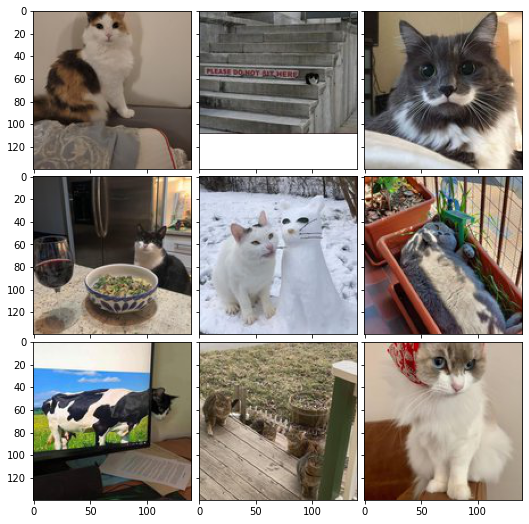

In [105]:
# Images of top cats
plot_top9(top_cats_thumb)

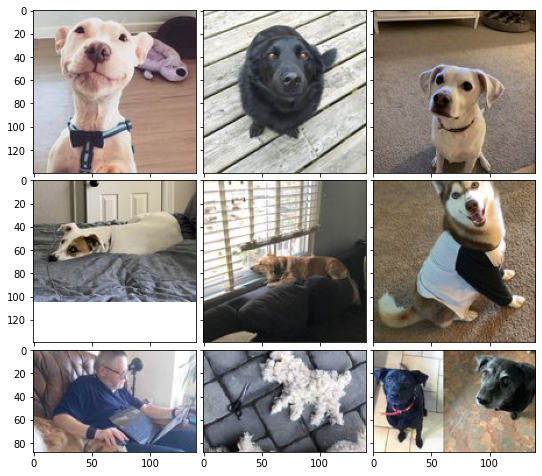

In [106]:
# Images of top dogs
plot_top9(top_dogs_thumb)